# COVID-19 Tweets

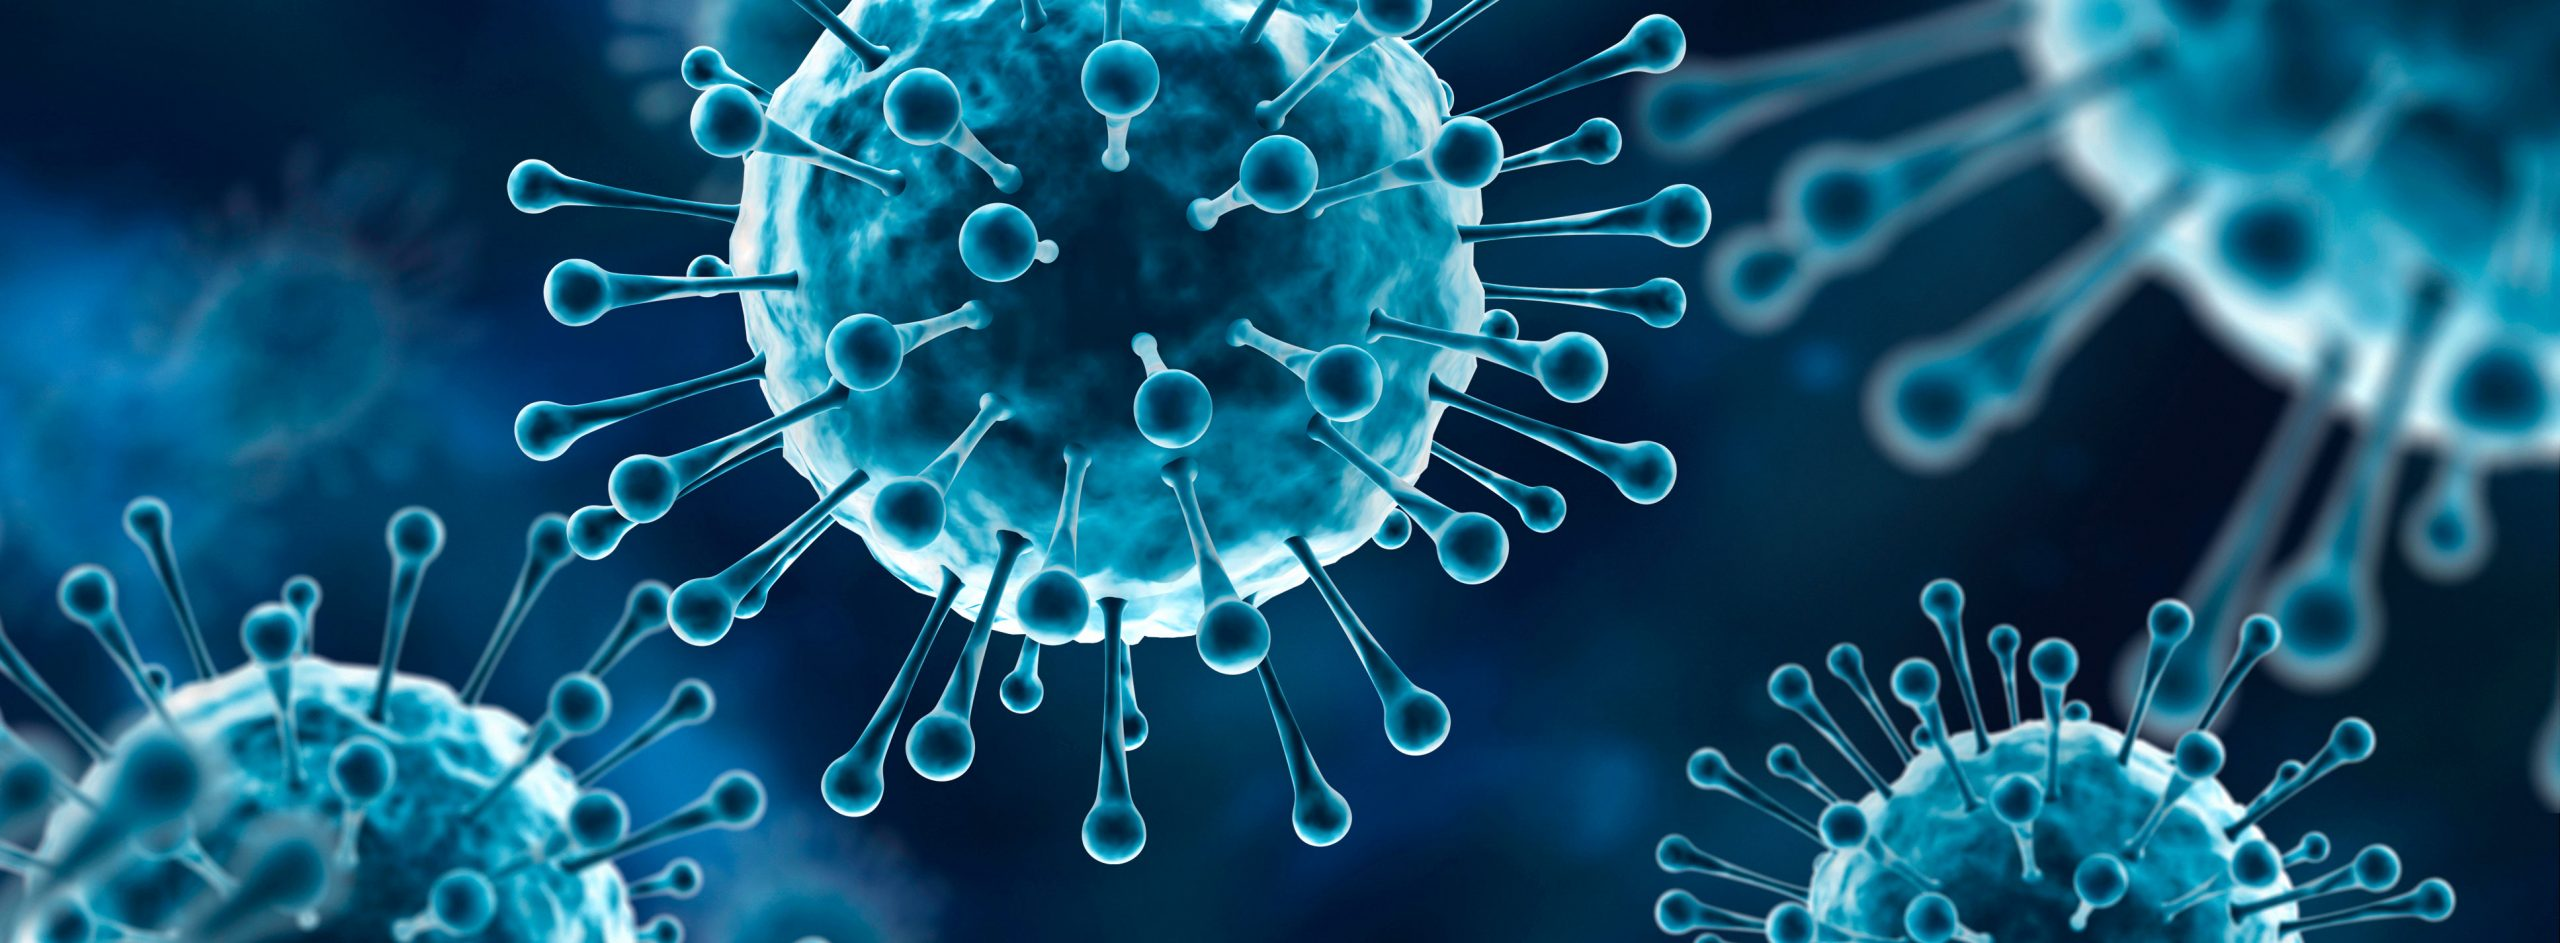

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Importing Necessary Libraries

In [ ]:
pip install dict_converter

In [ ]:
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set()
sns.palplot(sns.color_palette())
%matplotlib inline

import dict_converter
import re
import string
import datetime
from datetime import datetime
import nltk
from nltk.corpus import stopwords

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from tqdm import tqdm
import os

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image

In [ ]:
df = pd.read_csv("/kaggle/input/covid19-tweets/covid19_tweets.csv")

# Basic Information

In [ ]:
df.head(3)

In [ ]:
print(f"Dataset dimension:\n{df.shape}")

We have 82710 tweets in the train set

In [ ]:
print("Percentage of missing values")
print("============================")

for var in df.columns:
    if df[var].isna().sum() >0:
        miss = np.round(df[var].isna().sum()/df.shape[0] * 100,3)
        print(var, "has {0}% of missing values".format(miss))

In [ ]:
df.info()

In [ ]:
df.describe()

# Let's Explore The Tweets

In [ ]:
df.head(2)

In [ ]:
print("No. Of Unique Locations:",df["user_location"].nunique())

In [ ]:
df["n_of_texts"] = df["text"].apply(lambda x: len(x))
plt.figure(figsize=(7,4))
sns.kdeplot(df["n_of_texts"])
plt.title("Distribution Plot")
plt.xlabel("No. Of Text")
plt.show()

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(df["user_location"].value_counts().values[0:15],
            df["user_location"].value_counts().index[0:15]);
plt.title("Top 15 Location")
plt.xlabel("No. of tweets")
plt.ylabel("Location")
plt.show()

In [ ]:
plt.figure(figsize=(9,10))
num_texts = pd.DataFrame()
num_texts["user_location"] = df["user_location"]
num_texts["n_of_texts"] = df["n_of_texts"]

num_texts = num_texts.sort_values(by = "n_of_texts",ascending=False)
num_texts = num_texts.groupby("user_location").sum().sort_values(by = "n_of_texts",ascending=False)[:10]

sns.barplot(list(num_texts.values.flatten()),num_texts.index,)
plt.title("Top 10 Location By No. Of words")
plt.xlabel("No. Of Words")
plt.ylabel("Location")
plt.show()

In [ ]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [ ]:
# Applying the cleaning function to data
df['text_clean'] = df['text'].apply(str).apply(lambda x: text_preprocessing(x))

### Unigram plot

In [ ]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d


In [ ]:
unigrams = get_top_n_words(df['text_clean'],10)

unigram_df = pd.DataFrame(unigrams, columns = ['Text' , 'count']) #Creating df

#Plotting
plt.figure(figsize=(9,10))
sns.barplot(unigram_df["count"],unigram_df["Text"])
plt.title("Top 10 Unigrams")
plt.xlabel("Counts")
plt.ylabel("Text")
plt.show()

### Bigram plot

In [ ]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
bigrams = get_top_n_gram(df['text_clean'],(2,2),10)

bigram_df = pd.DataFrame(bigrams, columns = ['Text' , 'count']) #Creating df

#Plotting
plt.figure(figsize=(9,10))
sns.barplot(bigram_df["count"],bigram_df["Text"])
plt.title("Top 10 Bigrams")
plt.xlabel("Counts")
plt.ylabel("Text")
plt.show()

### Trigram Plot

In [ ]:
trigrams = get_top_n_gram(df['text_clean'],(3,3),10)

trigram_df = pd.DataFrame(trigrams, columns = ['Text' , 'count']) #Creating df

#Plotting
plt.figure(figsize=(9,10))
sns.barplot(trigram_df["count"],trigram_df["Text"])
plt.title("Top 10 Trigrams")
plt.xlabel("Counts")
plt.ylabel("Text")
plt.show()

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(df.drop(["is_retweet","user_verified"], axis = 1).corr(), annot=True)
plt.show()

In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_score(text):
    dict_res = sid.polarity_scores(text)
    return dict_res["compound"]

df["Score"] = df["text_clean"].apply(lambda x: get_score(x))   

In [ ]:
df['date'] = pd.to_datetime(df['date'])
dates = np.array(df['date'])
indices = np.argsort(dates)[10000:]
window = 750

dates = dates[indices][window:]
values = np.array(df['Score'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]

plt.figure(figsize=(20,9))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')
plt.title('Analysis of Tweets')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();

In [ ]:
df["Score"].describe()

Positive tweets are increasing from the first week of august

In [ ]:
df["Weekday"] = [datetime.weekday(date) for date in df["date"]]

def is_weekend(weekno):
    if weekno<5:
        return "Weekday"
    else:
        return "Weekend"
    
df["weekend_or_weekday"] = df["Weekday"].apply(lambda x: is_weekend(x))

In [ ]:
sns.barplot(df["Score"],df["weekend_or_weekday"])
plt.title("Weekend vs Weekday");

High negative tweets at weekends

In [ ]:
sentiment_countries = pd.DataFrame()
sentiment_countries["Score"] = df["Score"]
sentiment_countries["user_location"] = df["user_location"]

sentiment_countries = sentiment_countries.sort_values(by = "Score",ascending=False)
sentiment_countries = sentiment_countries.groupby("user_location").sum().sort_values(by = "Score",ascending=False)[:10]

plt.figure(figsize=(9,10))
sns.barplot(list(sentiment_countries.values.flatten()),sentiment_countries.index,)
plt.title("Top 10 Location By Positive Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Location")
plt.show()

### Thanks for reading this notebook.

##### Reference:
* https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert
* https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model